## Validate Dropout implementation

In [1]:
# dependencies
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from implementation.dropout import Dropout

np.random.seed(42)

In [2]:
# import dataset
train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)


train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

train[0][0].shape, train[0][1]

(torch.Size([1, 28, 28]), 9)

In [3]:
train.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Text(0.5, 1.0, '9')

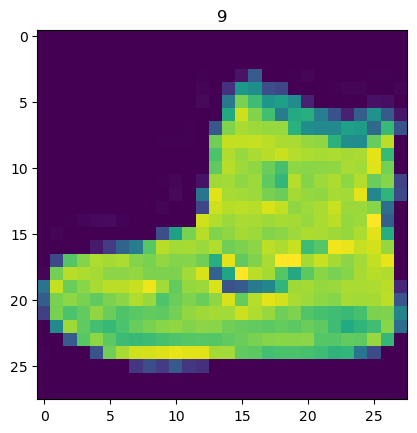

In [4]:
image, label = train[0]
plt.imshow(image.squeeze())
plt.title(label)

In [5]:
# baseline nn
class SimpleNetNoDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

In [6]:
class SimpleNetWithDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            Dropout(p),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

In [7]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [8]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

models = {
    "No Dropout": SimpleNetNoDropout(),
    "With Dropout": SimpleNetWithDropout(p=0.4),
}

for name, model in models.items():
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    print(f"\n=== {name} ===")
    for epoch in range(1, 16):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        acc = evaluate(model, test_loader, device)

        print(f"Epoch {epoch} | Loss: {train_loss:.4f} | Test Acc: {acc:.4f}")



=== No Dropout ===
Epoch 1 | Loss: 0.5232 | Test Acc: 0.8501
Epoch 2 | Loss: 0.3777 | Test Acc: 0.8461
Epoch 3 | Loss: 0.3382 | Test Acc: 0.8426
Epoch 4 | Loss: 0.3109 | Test Acc: 0.8709
Epoch 5 | Loss: 0.2927 | Test Acc: 0.8724
Epoch 6 | Loss: 0.2783 | Test Acc: 0.8745
Epoch 7 | Loss: 0.2651 | Test Acc: 0.8815
Epoch 8 | Loss: 0.2555 | Test Acc: 0.8765
Epoch 9 | Loss: 0.2439 | Test Acc: 0.8857
Epoch 10 | Loss: 0.2338 | Test Acc: 0.8863
Epoch 11 | Loss: 0.2252 | Test Acc: 0.8891
Epoch 12 | Loss: 0.2189 | Test Acc: 0.8839
Epoch 13 | Loss: 0.2111 | Test Acc: 0.8889
Epoch 14 | Loss: 0.2024 | Test Acc: 0.8866
Epoch 15 | Loss: 0.1954 | Test Acc: 0.8825

=== With Dropout ===
Epoch 1 | Loss: 0.5680 | Test Acc: 0.8228
Epoch 2 | Loss: 0.4193 | Test Acc: 0.8550
Epoch 3 | Loss: 0.3857 | Test Acc: 0.8660
Epoch 4 | Loss: 0.3657 | Test Acc: 0.8669
Epoch 5 | Loss: 0.3523 | Test Acc: 0.8742
Epoch 6 | Loss: 0.3408 | Test Acc: 0.8759
Epoch 7 | Loss: 0.3299 | Test Acc: 0.8754
Epoch 8 | Loss: 0.3218 | Tes

In [ ]:
""" 
TODO: 
- Fazer o dropout do padrão do artigo com escalonamento somente no teste
- Fazer rede neural mais complexa (talvez se baseando em redes feitas em outros artigos)
-
""" 